# Modern Data Structures Homework 3

Hsin-Ju (Lulu) Huang  
hh3105

In [36]:
import http
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime

# Part 1: Leverage the lecture code to answer these questions.
## 1. Use the BLS Data Finder 1.1 available here to import a BLS variable/field (using the BLS web API) of your choosing.

In [37]:
import requests
import pandas as pd

# CPI Series ID for Medical Care (U.S. city average)
med_care_series = "CUUR0000SAM"

# BLS API endpoint
bls_url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
headers = {"Content-type": "application/json"}

# Prepare request payload
request_payload = {
    "seriesid": [med_care_series],
    "startyear": "2023",
    "endyear": "2025"
}

# Request data from BLS
response = requests.post(bls_url, json=request_payload, headers=headers)
response_json = response.json()

# Extract and structure the data
med_data = response_json["Results"]["series"][0]["data"]
df_medcare = pd.DataFrame(med_data)

# Convert values and create datetime column
df_medcare["value"] = pd.to_numeric(df_medcare["value"], errors="coerce")
df_medcare["date"] = pd.to_datetime(
    df_medcare["year"] + "-" + df_medcare["period"].str[1:] + "-01", errors="coerce"
)

# Clean up and sort
df_medcare = df_medcare[["date", "value"]].dropna().sort_values("date")

# Display sample
print(df_medcare.head())

         date    value
26 2023-01-01  551.422
25 2023-02-01  549.487
24 2023-03-01  547.805
23 2023-04-01  547.219
22 2023-05-01  547.420


## 2. [10 pts] Using the BLS web API, create your own custom function which can interact with the BLS web API. Your function should take three input parameters: name base_url_in, series_in, and title_in and return the relevant data series as a pd.DataFrame object. Test your function by replicating the GET request you sent above for #1.

In [38]:
def fetch_bls_series(base_url_in, series_in, title_in):
    headers = {"Content-type": "application/json"}
    payload = {
        "seriesid": [series_in],
        "startyear": "2023",
        "endyear": "2025"
    }
    
    response = requests.post(base_url_in, json=payload, headers=headers)
    response_json = response.json()
    
    if 'Results' not in response_json:
        print("Error in response:", response_json)
        return pd.DataFrame()
    
    data_points = response_json["Results"]["series"][0]["data"]
    df = pd.DataFrame(data_points)
    
    # Data cleaning
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df["date"] = pd.to_datetime(
        df["year"] + "-" + df["period"].str[1:] + "-01", errors="coerce"
    )
    df["series_title"] = title_in
    
    df = df[["date", "value", "series_title"]].dropna().sort_values("date")
    return df


In [39]:
# Inputs
base_url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
series_id = "CUUR0000SAM"  # Medical care CPI
series_title = "CPI: Medical Care"

# Call the custom function
df_med = fetch_bls_series(base_url, series_id, series_title)

# Check the result
print(df_med.head())

         date    value       series_title
26 2023-01-01  551.422  CPI: Medical Care
25 2023-02-01  549.487  CPI: Medical Care
24 2023-03-01  547.805  CPI: Medical Care
23 2023-04-01  547.219  CPI: Medical Care
22 2023-05-01  547.420  CPI: Medical Care


## 3. [10 pts] Go to these three links: link1, link2, link3. On these webpages, you will see three different time series data sets. For each, you will also see both a Series Title and ID. Using the function you wrote to fetch data from the BLS web API, import these data sets into Python as three separate pd.Data.Frame objects.

In [40]:
# Define the base API URL
base_url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

# Series 1: Eggs (white, large)
df_eggs_white = fetch_bls_series(base_url, "APU0000709112", "Eggs (White, Grade A, Large)")

# Series 2: Milk (whole, fortified)
df_milk = fetch_bls_series(base_url, "APU000074714", "Milk (Whole, Fortified)")

# Series 3: Eggs (grade A, large)
df_eggs_large = fetch_bls_series(base_url, "APU0000708111", "Eggs (Grade A, Large)")

# Quick check on the outputs
print(df_eggs_white.head())
print(df_milk.head())
print(df_eggs_large.head())

         date  value                  series_title
26 2023-01-01  4.204  Eggs (White, Grade A, Large)
25 2023-02-01  4.163  Eggs (White, Grade A, Large)
24 2023-03-01  4.098  Eggs (White, Grade A, Large)
23 2023-04-01  4.042  Eggs (White, Grade A, Large)
22 2023-05-01  4.042  Eggs (White, Grade A, Large)
         date  value             series_title
26 2023-01-01  3.452  Milk (Whole, Fortified)
25 2023-02-01  3.514  Milk (Whole, Fortified)
24 2023-03-01  3.551  Milk (Whole, Fortified)
23 2023-04-01  3.735  Milk (Whole, Fortified)
22 2023-05-01  3.685  Milk (Whole, Fortified)
         date  value           series_title
26 2023-01-01  4.823  Eggs (Grade A, Large)
25 2023-02-01  4.211  Eggs (Grade A, Large)
24 2023-03-01  3.446  Eggs (Grade A, Large)
23 2023-04-01  3.270  Eggs (Grade A, Large)
22 2023-05-01  2.666  Eggs (Grade A, Large)


## 4. [10 pts] Merge the data sets together into a single pd.DataFrame and make a time series plot showing how the CPI for these three goods has changed over the last 24 months. Each good should be shown as a unique line with different coloring/patterns and a matching legend (I suggest using the matplotlib library to do this).

In [41]:
# Combine all three into a single DataFrame
merged_cpi = pd.concat([df_eggs_white, df_milk, df_eggs_large], ignore_index=True)

# Filter to only include data from the last 24 months
cutoff_date = pd.Timestamp.today() - pd.DateOffset(months=24)
merged_recent = merged_cpi[merged_cpi['date'] >= cutoff_date]

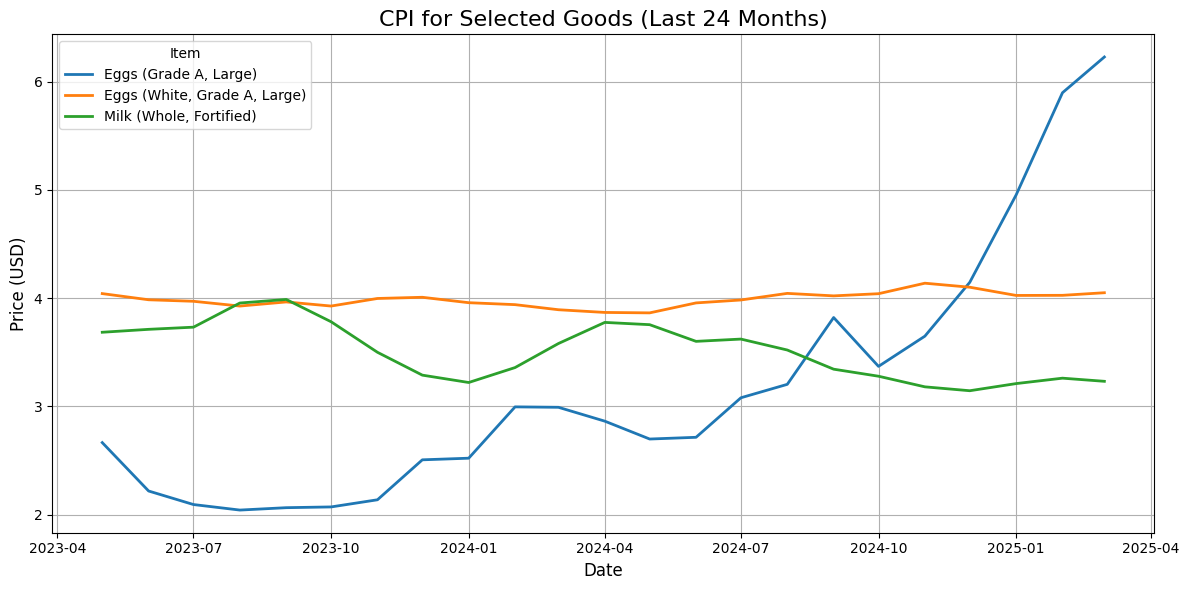

In [42]:
# Set up the plot
plt.figure(figsize=(12, 6))

# Plot each series separately using groupby
for title, group in merged_recent.groupby('series_title'):
    plt.plot(group['date'], group['value'], label=title, linewidth=2)

# Customize the plot
plt.title("CPI for Selected Goods (Last 24 Months)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend(title="Item")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

## 5. [10 pts] In the lecture notes, refer to the section entitled "No Python Package? Manipulate URL directly". Can you update the code in the New York Times article search API URL so that you return article data for Hillary Clinton for the time range April 1, 2024 - April 4, 2024? How many TOTAL articles were returned by this API search?


In [43]:
article_key = "uLl2mFS2e5fDcH1bhg3xAzVibJ7wFmWG"  
term = "Hillary+Clinton"  # Search term, use + between words
begin_date = "20240401"   # April 1, 2024
end_date = "20240404"     # April 4, 2024

# Step 2: Build the API URL
finalurl = (
    "http://api.nytimes.com/svc/search/v2/articlesearch.json?"
    + "q=" + term
    + "&begin_date=" + begin_date
    + "&end_date=" + end_date
    + "&api-key=" + article_key
)

# Step 3: Make the request
r = requests.get(finalurl)
r = r.json()

# Step 4: Explore the returned JSON
print(r.keys())  # Should see 'response' among the keys

# Step 5: Load articles into a DataFrame
data = pd.DataFrame(r['response']['docs'])

# Step 6: Print how many articles were returned
print("Number of articles returned:", data.shape[0])

# Step 7: Look at columns available
print("Columns:", data.columns.tolist())

# Step 8: Show the data
data.head()

dict_keys(['status', 'copyright', 'response'])
Number of articles returned: 5
Columns: ['abstract', 'byline', 'document_type', 'headline', '_id', 'keywords', 'multimedia', 'news_desk', 'print_page', 'print_section', 'pub_date', 'section_name', 'snippet', 'source', 'subsection_name', 'type_of_material', 'uri', 'web_url', 'word_count']


,abstract,byline,document_type,headline,_id,keywords,multimedia,news_desk,print_page,print_section,pub_date,section_name,snippet,source,subsection_name,type_of_material,uri,web_url,word_count
0,Inside the notorious “catch and kill” campaign...,{'original': 'By Lachlan Cartwright'},article,{'main': 'What I Saw Working at The National E...,nyt://article/3211e3f0-4388-5f19-884b-051e5821...,"[{'name': 'Organization', 'value': 'National E...","{'caption': '', 'credit': 'Photo illustration ...",Magazine,26,MM,2024-04-03T09:04:03Z,Magazine,Inside the notorious “catch and kill” campaign...,The New York Times,,News,nyt://article/3211e3f0-4388-5f19-884b-051e5821...,https://www.nytimes.com/2024/04/03/magazine/na...,6394
1,Oren Etzioni was once an optimist about artifi...,{'original': 'By Cade Metz and Tiffany Hsu'},article,{'main': 'An A.I. Researcher Takes On Election...,nyt://article/e75ea126-164f-5942-a86a-4781dfdd...,"[{'name': 'Subject', 'value': 'Artificial Inte...",{'caption': 'Oren Etzioni at The AI Institute....,Business,1,B,2024-04-02T16:00:12Z,Technology,Oren Etzioni was once an optimist about artifi...,The New York Times,,News,nyt://article/e75ea126-164f-5942-a86a-4781dfdd...,https://www.nytimes.com/2024/04/02/technology/...,1089
2,Simon Rosenberg has spent the past two years t...,{'original': 'By Adam Nagourney'},article,{'main': 'Many Democrats Are Worried Trump Wil...,nyt://article/58c63816-3116-5608-b18d-878e39eb...,"[{'name': 'Person', 'value': 'Biden, Joseph R ...","{'caption': 'Simon Rosenberg, a Democratic str...",Politics,18,A,2024-04-03T18:26:38Z,U.S.,Simon Rosenberg has spent the past two years t...,The New York Times,Politics,News,nyt://article/58c63816-3116-5608-b18d-878e39eb...,https://www.nytimes.com/2024/04/03/us/politics...,1754
3,He oversaw design of new ballparks for the Bal...,{'original': 'By Richard Sandomir'},article,"{'main': 'Larry Lucchino, Top Executive at Thr...",nyt://article/47823689-65b3-5250-ba60-8c10cff9...,"[{'name': 'Subject', 'value': 'Deaths (Obituar...",{'caption': 'Larry Lucchino in 2008 as preside...,Obits,11,B,2024-04-02T16:23:20Z,Sports,He oversaw design of new ballparks for the Bal...,The New York Times,Baseball,Obituary (Obit),nyt://article/47823689-65b3-5250-ba60-8c10cff9...,https://www.nytimes.com/2024/04/02/sports/base...,1285
4,Long before the killings of seven workers in G...,{'original': 'By Kim Severson'},article,{'main': 'How José Andrés and His Corps of Coo...,nyt://article/5b4d71e7-2855-534f-b725-7cfd9c88...,"[{'name': 'Person', 'value': 'Andres, Jose (19...","{'caption': 'José Andrés, the Spanish chef who...",Dining,9,A,2024-04-02T22:31:38Z,Food,Long before the killings of seven workers in G...,The New York Times,,News,nyt://article/5b4d71e7-2855-534f-b725-7cfd9c88...,https://www.nytimes.com/2024/04/02/dining/jose...,1456


5 articles were returned.

## 6. [15 pts] In this question, we will connect to the Spotify API. Spotify has a package called spotipy which makes this easy. Using their API documentation, your task is to figure out how to use the album function listed on this webpage to import Queen's Greatest Hits album. Once you have successfully used spotipy to pull in data for this album, write a for loop to display the following message, making sure you align the numbers as is done here:

In [44]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Step 1: Authenticate
cid = '1d79c7320efe48be8555674d48a7fd2d'
secret = '34a7cabc5f624302b9bb25c29d1c8057'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Step 2: Album ID for Queen's Greatest Hits
album_id = '6i6folBtxKV28WX3msQ4FE'

# Step 3: Fetch the album data
album_data = sp.album(album_id)
tracks = album_data['tracks']['items']

# Step 4: Print each track nicely
for idx, track in enumerate(tracks, start=1):
    print(f"Track {idx:2}  is {track['name']}")

Track  1  is 20th Century Fox Fanfare
Track  2  is Somebody To Love
Track  3  is Doing All Right - ...Revisited
Track  4  is Keep Yourself Alive - Live At The Rainbow
Track  5  is Killer Queen
Track  6  is Fat Bottomed Girls - Live In Paris
Track  7  is Bohemian Rhapsody
Track  8  is Now I'm Here - Live At The Hammersmith Odeon
Track  9  is Crazy Little Thing Called Love
Track 10  is Love Of My Life - Live At Rock In Rio
Track 11  is We Will Rock You - Movie Mix
Track 12  is Another One Bites The Dust
Track 13  is I Want To Break Free
Track 14  is Under Pressure
Track 15  is Who Wants To Live Forever
Track 16  is Bohemian Rhapsody - Live Aid
Track 17  is Radio Ga Ga - Live Aid
Track 18  is Ay-Oh - Live Aid
Track 19  is Hammer To Fall - Live Aid
Track 20  is We Are The Champions - Live Aid
Track 21  is Don't Stop Me Now - ...Revisited
Track 22  is The Show Must Go On


## 7. [15 pts] Find an API of interest to you. Sign up for an API key if necessary. Describe the API concisely and make a single call on the API and return an example of the returned data here.

In [47]:
import requests

api_key = '7fa43971ab2b69a6bb9edfdd0ffe57b2'
city = 'New York'
base_url = 'https://api.openweathermap.org/data/2.5/weather'

# Build URL
params = {
    'q': city,
    'appid': api_key,
    'units': 'metric'  # Get temperature in Celsius
}

# Make API request
response = requests.get(base_url, params=params)
weather_data = response.json()

# Print example output
print(weather_data)


{'coord': {'lon': -74.006, 'lat': 40.7143}, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'base': 'stations', 'main': {'temp': 21.15, 'feels_like': 21.44, 'temp_min': 18.3, 'temp_max': 23, 'pressure': 1008, 'humidity': 81, 'sea_level': 1008, 'grnd_level': 1007}, 'visibility': 10000, 'wind': {'speed': 9.26, 'deg': 250, 'gust': 16.46}, 'clouds': {'all': 100}, 'dt': 1745691108, 'sys': {'type': 2, 'id': 2008776, 'country': 'US', 'sunrise': 1745661648, 'sunset': 1745711187}, 'timezone': -14400, 'id': 5128581, 'name': 'New York', 'cod': 200}


I chose the OpenWeatherMap API, which provides real-time and forecast weather data globally. I made a simple call to get the current weather for New York City. The returned data included temperature, weather description, wind speed, and humidity.

## 8. [20 pts] Import the data found in the HW5 folder. It is a single column of data that has 500 rows. This data represents a format of data that you will often encounter in research projects which use "thematic coding" for text response data. As described here: "Thematic coding is a form of qualitative analysis that involves recording or identifying passages of text or images that are linked by a common theme or idea allowing you to index the text into categories and therefore establish a 'framework of thematic ideas about it' (Gibbs 2007)."

It is ok if you are not familiar with thematic coding for qualitative/text data. Your task is to import the data and write a regex that is capable of finding the thematic code "1" whenever it appears in the string. This is more difficult than it sounds, because your regex should count all the "1"s that appear, but not "10", "11", "12", "21" etc. Also note, that sometimes "1" appears in the 2nd, 3rd... etc. position (e.g., "2, 6, 7, 1, 10"). Use this regex to add a new column to your dataset called "find_1". Display a frequency table showing the number of times your regex flagged "1" as appearing.

In [46]:
import pandas as pd
import re

# Step 1: Load the dataset
data = pd.read_csv(r"C:\Users\lulu\Documents\GitHub\QMSS-GR5072-Spring2025_Class\HW\HW05\data\Thematic codes data.csv")

# Step 2: Define a regex pattern that matches only the standalone number "1"
regex_pattern = r'(?<!\d)1(?!\d)'

# Step 3: Search each text line for matches of "1" (not part of 10, 11, etc.)
data['find_1'] = data['Thematic codes'].apply(lambda text: len(re.findall(regex_pattern, str(text))))

# Step 4: Create a binary column: 1 if "1" was found, 0 if not
data['has_1'] = data['find_1'].apply(lambda count: 1 if count > 0 else 0)

# Step 5: Generate a frequency table
freq_table = data['has_1'].value_counts().rename(index={0: 'No 1 Found', 1: '1 Found'})

# Step 6: Display the result
print(freq_table)


has_1
No 1 Found    437
1 Found        63
Name: count, dtype: int64
